In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from tqdm import tqdm
import sys
import matplotlib as mpl

sys.path.insert(0, '../methods/')

sys.modules.pop('generate_syn_data', None)
from generate_syn_data import *

sys.modules.pop('ARWQE', None)
from ARWQE import *

sys.modules.pop('algo_syn', None)
from algo_syn import *

sys.modules.pop('plots', None)
from plots import *


In [67]:
def simulate(seed, num_periods, true_means, variance, B_arr, B_arr_tr, fixed_windows, train_windows, num_trials, alpha, delta, next_period, rho):

    np.random.seed(seed)

    #B_arr is for val set
    B_arr_ends = np.cumsum(B_arr) - 1
    B_arr_tr_ends = np.cumsum(B_arr_tr) - 1

    cdf_array = np.empty((num_trials, len(fixed_windows)+2, len(train_windows), num_periods))
    interval_array = np.empty((num_trials, len(fixed_windows)+2, len(train_windows), num_periods))

    seeds = np.arange(num_trials) + 2024

    for (trial, seed) in tqdm(enumerate(seeds)):
        
        np.random.seed(seed)

        X_val = generate_gaussian_sequence(B_arr = B_arr, true_means = true_means, variance=variance)
        X_tr = generate_gaussian_sequence(B_arr = B_arr_tr, true_means = true_means, variance=variance)

        for t in range(num_periods):
            
            idx_tr = B_arr_tr_ends[t]+1
            idx_val = B_arr_ends[t]+1

            mu_hats = np.array(train_synthetic(X_tr[:idx_tr], B_arr_tr[:t+1], train_windows))

            if next_period == True:
                mu_t = true_means[t+1]
            else: 
                mu_t = true_means[t]

            B_arr_t = B_arr[:t+1]

            for m, mu_hat in enumerate(mu_hats):
            #calculate conformity score
                S_t = np.abs(X_val[:idx_val] - mu_hat)
                
                khat, qt_khat, qtk_all = ARWQE(S_t, B_arr_t, alpha, delta)
                coverage_ARW = calculate_coverage(mu_hat, qt_khat, mu_t, variance)

                cdf_array[trial, 0, m, t] = coverage_ARW
                interval_array[trial, 0, m, t] = 2*qt_khat
            
                #baseline: weighted quantile
                qw = QE_weighted(S_t, B_arr_t, alpha, rho)
                coverage_w = calculate_coverage(mu_hat, qw, mu_t, variance)
                cdf_array[trial, 1, m, t] = coverage_w
                interval_array[trial, 1, m, t] = 2*qw

                #baseline: take quantile of fixed k
                for ik, k in enumerate(fixed_windows):
                    #qtk = QE_fixed(S_t, B_arr_t, alpha, k)
                    log2k = int(np.log2(k))
                    qtk = qtk_all[min(log2k, len(qtk_all)-1)]
                    coverage_k = calculate_coverage(mu_hat, qtk, mu_t, variance)
                    cdf_array[trial, ik+2, m, t] = coverage_k
                    interval_array[trial, ik+2, m, t] = 2*qtk 
                
            
    return cdf_array, interval_array

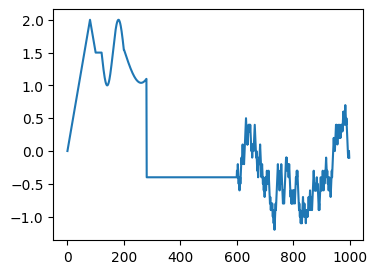

50it [06:15,  7.51s/it]


In [90]:
num_periods = 1000
seed = 6
np.random.seed(seed)
B_arr = np.random.randint(low=1, high=10, size=num_periods)

fixed_windows = [1, 4, 16, 64, 256, 1024]
train_windows = [1, 64, 256, 1024]

num_trials = 50
variance = 1
alpha, delta, gamma = 0.1, 0.1, 1
rho = 0.99

#stationary case
#true_means = 5 * np.ones(num_periods)

#NOTE: change shift patterns
#true_means = 2 * np.sin(np.linspace(0, 3 * np.pi, 1000)) + 5

#NOTE: this might work
true_means = 5 * generate_true_means(num_periods-1, 40, 10)

plt.figure(figsize=(4,3))
plt.plot(true_means)
plt.show()

#NOTE: change this to (not) predict for the next period instead
next_period = False

parameters = {
    "seed": seed,
    "num_periods": num_periods,
    "true_means": true_means,
    "B_arr": B_arr,
    "B_arr_tr": 1 * B_arr,  # This will be calculated based on B_arr
    "fixed_windows": fixed_windows,
    "train_windows": train_windows,
    "num_trials": num_trials,
    "variance": variance, 
    "alpha": alpha, "delta": delta, 
    "next_period": next_period,
    "rho": rho
}

cdf_array, interval_array = simulate(**parameters)

[0.03302278 0.0729277  0.15333164 0.05608308 0.03015822 0.02870536
 0.04458297 0.0729277 ]
[0.02533508 0.07382485 0.15237665 0.05663232 0.03074518 0.022476
 0.03719757 0.07382485]
[0.03029461 0.07744505 0.15286478 0.05687782 0.03181509 0.03100275
 0.04515584 0.07744505]
[0.03445278 0.05391116 0.15337069 0.05752766 0.03316345 0.03392992
 0.05136756 0.05391116]


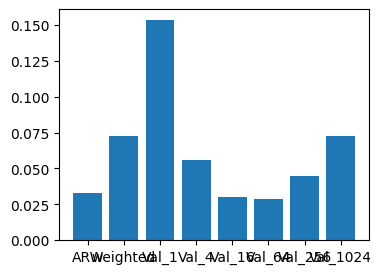

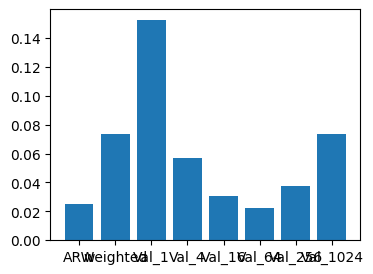

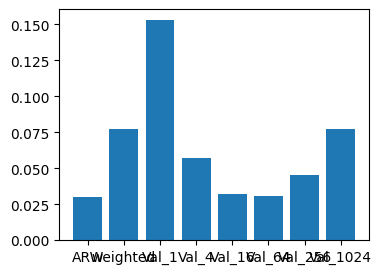

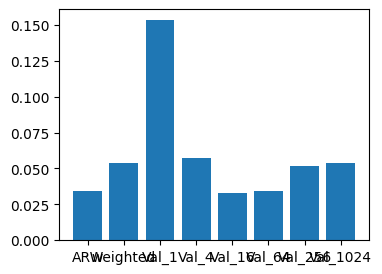

In [91]:
#process results in cdf_dict
methods = ['ARW'] + ['weighted'] + [f'Val_{k}' for k in fixed_windows]

mae_array = np.abs(cdf_array - 1 + alpha)
mse_array = (cdf_array - 1 + alpha)**2

results = {}
for m in range(len(train_windows)):
    mae = np.mean(np.mean(mae_array[:, :, m, 100:], axis=2), axis=0)
    se_ae = np.std(np.mean(mae_array[:, :, m, 100:], axis=2), axis=0) / np.sqrt(num_trials)

    interval = np.mean(np.mean(interval_array[:, :, m, 100:], axis=2), axis=0)
    se_interval = np.std(np.mean(interval_array[:, :, m, 100:], axis=2), axis=0) / np.sqrt(num_trials)
    print(mae)
    results[train_windows[m]] = (mae, se_ae, interval, se_interval)
    
    plt.figure(figsize=(4,3))
    plt.bar(methods, mae)



In [92]:
np.save('./results/mean_unstationary_cdf_array.npy', cdf_array, allow_pickle=True)
np.save('./results/mean_unstationary_itv_array.npy', interval_array, allow_pickle=True)

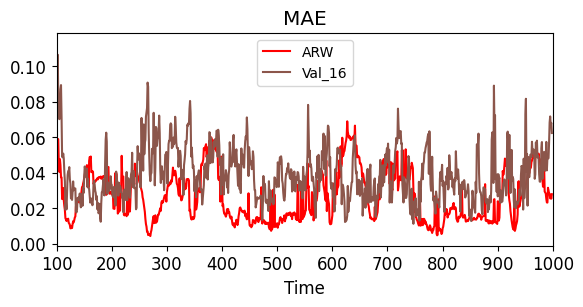

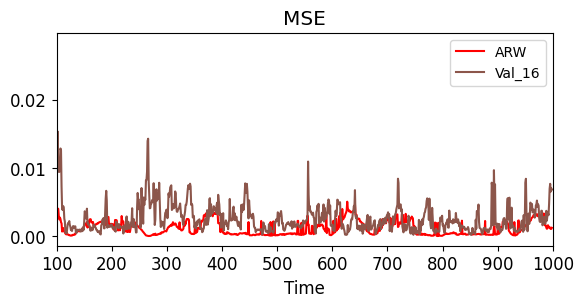

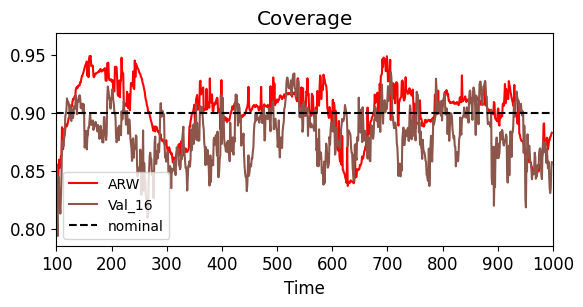

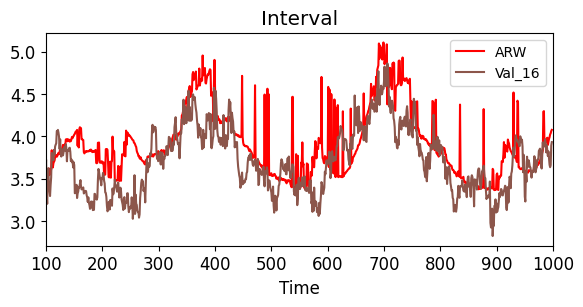

In [14]:
#plot cdf over time periods for ARW, V1, V256
colors = ['r', '#FFA500', 'tab:purple', 'tab:brown', 'tab:green', '#0096FF', 'tab:gray']
methods = ['ARW', 'Val_1', 'Val_4', 'Val_16', 'Val_64', 'Val_256', 'Val_1024']

#NOTE: uncomment to change the index of the methods to plot
methods_to_plot = [0, 3]

mae_over_trials = np.mean(mae_array[:, :, :], axis=1)
mse_over_trials = np.mean(mse_array[:, :, :], axis=1)
cdf_over_trials = np.mean(cdf_array[:, :, :], axis=1)
interval_over_trials = np.mean(interval_array[:, :, :], axis=1)
plot_over_time(colors, methods, 100, 1000, mae_over_trials, methods_to_plot, title='MAE')
plot_over_time(colors, methods, 100, 1000, mse_over_trials, methods_to_plot, title='MSE')
plot_over_time(colors, methods, 100, 1000, cdf_over_trials, methods_to_plot, title='Coverage', alpha=0.1)
plot_over_time(colors, methods, 100, 1000, interval_over_trials, methods_to_plot, title='Interval')

#plt.savefig(f'{DATAPATH}/{figname}_time_var{variance}.png', dpi=300, bbox_inches='tight')